# Image Pre-Processing

This Image Processing toolbox is essentially a stripped down, more stable, version of the tools available in [Neurosetta](https://github.com/NikDrummond/Neurosetta), which also has more in depth explanations for image processing [here](https://github.com/NikDrummond/Neurosetta/blob/main/Tutorials/Image_Processing.ipynb), although is also very much a work in progress.

Here, I will cover:

    - reading and plotting a .tiff file
    - Contrast Enhancement/histogram Normalisation using CLAHE
    - Generating a mask using Gaussian Blurring
    - Thresholding an image using Generalised Histogram Thresholding

There will be a second tutorial for extracting image metrics.

## Reading and plotting images

The `read_Image` function take a path - either to a specific file, or a directory, and returns and 'Image' object (or `Image_list` if a directory is given). The most important attribute of an `Image` is `array` which is a `numpy.array` of the image. 

Plotting an image is as easy as using the `plot` function, which returns a `matplotlib.pyplot Figure` and `Axes` object. For simplicity, you have limited options here, but an important one is `figsize` which takes a tuple as input and determines the size of the plot. 

import the Image Processing package as IP:


In [11]:
import Image_Processing as IP


There is an image file in the same location as this notebook, the the path is just the file name - you will need to change this to whatever image you are using!!

In [12]:
path = "13.04.22_B1O1D1_x45_y290_layer1.tif"

We can then use `read_Image` and `plot` to have a look at the original image:

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'13.04.22_B1O1D1_x45_y290_layer1'}, xlabel='X', ylabel='Y'>)

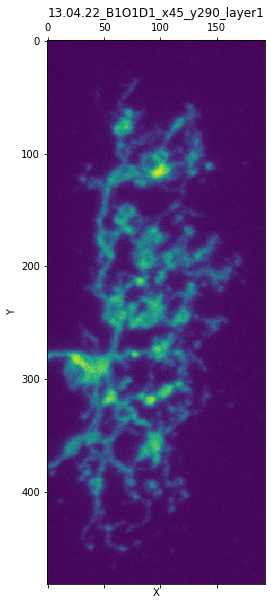

In [13]:
N = IP.read_Image(path)
IP.plot(N, figsize = (10,10))


## CLAHE 

The next step is to apply CLAHE, which enhances the contrast in the image, and plot it to have a look: 

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'13.04.22_B1O1D1_x45_y290_layer1'}, xlabel='X', ylabel='Y'>)

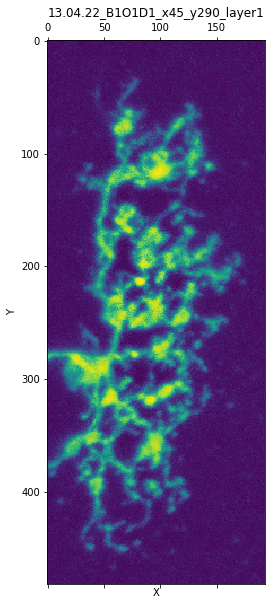

In [14]:
N = IP.contrast_enhancement(N)
IP.plot(N, figsize = (10,10))


If we like how this looks we can then save the image - we just need to make a folder where we want to save things, and set that path. 

The `Image` object has an attribute `name` which is the original file name. We can use this to keep the file names the same across folders. 

Unlike the other functions in the `Image_Processing` package, the save function is what is called a `class method`, so rather than calling it independently from the package, you call it from the image object itself, in this example, `N`:

In [15]:
# The folder we want to save to 
CLAHE_save_path = 'CLAHE_eg/'

# Merge the image file name with the folder name to create the full save path
p = CLAHE_save_path + N.name

# save our tiff...
N.save_tiff(p)

## Getting an image threshold

We are using a method called Generalised Histogram Thresholding to automatically determine a threshold for the images... this has, in my experience worked pretty well.

With the same function, we can either get a value of t, our threshold or directly apply it to an image.

The function is simply `IP.threshold`



In [16]:
# If we just want the threshold value:
t = IP.threshold(N, apply = False)
print(t)


28.0


If we want to directly apply the threshold to an image, we can just set the `apply` argument to `True`, and plot it:

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'13.04.22_B1O1D1_x45_y290_layer1'}, xlabel='X', ylabel='Y'>)

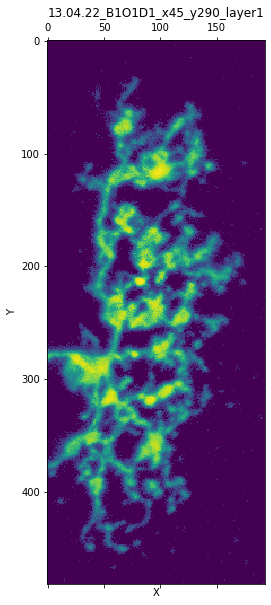

In [17]:
N = IP.threshold(N, apply = True)
IP.plot(N,figsize = (10,10))

There is not a huge difference here noticeable to the eye, but as we noted before, the threshold value is 14, so any value less than 14 has now been set to 0 in the image.

## Gaussian Blurring

In some instances, after we may want a mask around the area of the neuron in the image. This can be done by creating a mask based on a Blurred version of the image.

This is useful for a couple of reasons. First, we may have little bits of signal outside the neuron left over after thresholding, and this is a good way of removing them. Second, we in the future will want to count puncta which overlap with the neuron itself - this is how we find the ones which overlap with our neuron. 

To do this, we have a nice blurring function, you only have to set the value of sigma, which determines the width at half maximum of the gaussian kernel we use to blur the image. Setting this appropriately may take some eyeballing, but is set to 8 pixels by default.

The function we want is `blur_image` and is applied directly to an image so we can use it and plot the neuron like so:

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'13.04.22_B1O1D1_x45_y290_layer1'}, xlabel='X', ylabel='Y'>)

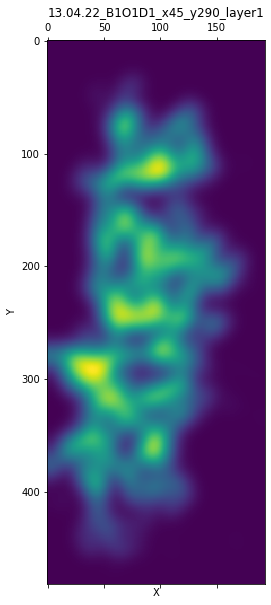

In [18]:
N = IP.blur_image(N)
IP.plot(N, figsize = (10,10))

As we can see the image is now heavily blurred... we can use this to extract a mask, by thresholding and then binarising the resulting blurred image. 

First of all, we need to get the threshold value:

t = IP.threshold(N,apply = False)